In [30]:
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from io import StringIO
import datetime
from sklearn.preprocessing import normalize

now = datetime.datetime.now().strftime(format="%Y-%m-%d_%H-%M")

# Chargement donnees
df_train = pd.read_csv('../data/train-sep.csv')

# Separation des donnees et pretraitement
X_train_raw = df_train['titre']
y_train_raw = df_train['type']

# Preprocess sur les donnees de trainentraines
preprocessed_text_train = [simple_preprocess(sentence, min_len = 1) for sentence in X_train_raw]

# Train modele Word2Vec 
model = Word2Vec(sentences = preprocessed_text_train, vector_size=100, window=5, min_count=1, workers=4)

# Transformation donnees à plongments Word2Vec 
X_train = np.array([np.mean([model.wv[word] for word in words if word in model.wv] or [np.zeros(100)], axis=0) for words in preprocessed_text_train])

# Encodage des labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_raw)

# Chargement des donnees de test
df_test = pd.read_csv('../data/test.csv')
X_test = df_test['titre']

# Preprocess sur les donnees de tests
preprocessed_text_test = [simple_preprocess(sentence, min_len=1) for sentence in X_test]

# Transformation donnees de texte test en plongement Word2Vec
X_test_emb = np.array([model.wv[word] for sentence in preprocessed_text_test for word in sentence if word in model.wv])

# Train SVM classifier
classifier = SVC(kernel='linear')
classifier.fit(X_train, y_train_encoded)

# Prediction encode de donnees de test
y_pred_encoded = classifier.predict(X_test_emb)
y_pred_encoded = y_pred_encoded[:len(df_test)]

# Decodage de predictions
y_pred = label_encoder.inverse_transform(y_pred_encoded)

In [28]:
# Création d'un DataFrame pour comparer les prédictions et les références
resultats = pd.DataFrame({
    'Titre': X_test,
    'Categorie Prédite': y_pred
})

# Réinitialisation de l'index pour une meilleure lisibilité
resultats.reset_index(drop=True, inplace=True)

# Affichage du tableau des résultats
print(resultats)

# Optionnel: Sauvegarder le tableau dans un fichier CSV
resultats.to_csv('../data/result_word2vec.csv', index=False)

y_true = df_test['type']
precision = accuracy_score(y_true, y_pred)
print(f'Précision du modèle : {precision} \n -----------------------------\n')

# Génération d'un rapport de classification
rapport_classification = classification_report(y_true, y_pred)
print('Rapport de classification :\n', rapport_classification)

rapport_df = pd.read_fwf(StringIO(rapport_classification), delimiter=';', header=0)
rapport_df.to_csv(f'../data/result/result_word2vec_{now}.csv', index=False)

                                                  Titre Categorie Prédite
0                          Roulé à la confiture de lait    Plat principal
1                                Croissants aux amandes    Plat principal
2     Quinoa Phileas (aux légumes croquants et sauci...    Plat principal
3                   Magret de canard à la crème de mûre    Plat principal
4     St-Jacques a la sauce aux huitres et aux asperges    Plat principal
...                                                 ...               ...
1383             Galettes de pommes de terre aux navets    Plat principal
1384  Terrine d'aubergines au thon de Nadine (4ème r...           Dessert
1385              Gateau aux amandes et fleur d'oranger    Plat principal
1386                               Cailles au vin rouge    Plat principal
1387  Gratin de pâtes au boeuf, courgettes et mascar...    Plat principal

[1388 rows x 2 columns]
Précision du modèle : 0.4452449567723343 
 -----------------------------

Rapport de cl

/home/leon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 18   0 389]
 [ 20   0 317]
 [ 44   0 600]]


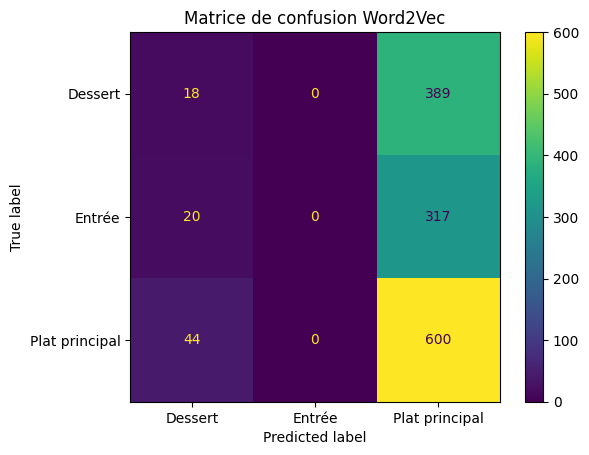

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay

fig = ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
fig.ax_.set_title("Matrice de confusion Word2Vec")

print(fig.confusion_matrix)